Lookback put option (floating strike) validation


For validation purposes, we compared the results from our implementation of the floating strike look-back put option with the convergence and performance values provided in Broadie, Glasserman, and Kou (1999). 

"Broadie, M., Glasserman, P., & Kou, S.G. (1999). Connecting discrete and continuous path-dependent options. Finance and Stochastics, 3(1), 55-82. doi:10.1007/s007800050054"

In [17]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from qablet_contracts.timetable import py_to_ts
from qablet.black_scholes.mc import LVMCModel
from src.contracts.lookback import lookback_put_timetable

In [20]:
MC_PARAMS = {
    "PATHS": 100_000,
    "TIMESTEP": 1000,
     "SEED": 1,
}

# Provided data functions
def basic_info():

    return {
        "prc_dt": datetime(2005, 9, 14),
        "ticker": "SPX",
        "ccy": "USD",
        "spot": 100,  # Using spot price as 100
    }

def assets_data(rate=0.1):
    info = basic_info()

    div_rate = 0
    times = np.array([0.0, 5.0])
    rates = np.array([rate, rate])
    discount_data = ("ZERO_RATES", np.column_stack((times, rates)))

    fwds = info["spot"] * np.exp((rates - div_rate) * times)
    fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

    return {info["ccy"]: discount_data, info["ticker"]: fwd_data}

def localvol_data(rate=0.1):
    info = basic_info()


    return {
        "BASE": "USD",
        "PRICING_TS": py_to_ts(info["prc_dt"]).value,
        "ASSETS": assets_data(rate=rate),
        "MC": MC_PARAMS,
        "LV": {"ASSET": "SPX", "VOL": 0.3},
    }

In [21]:
if __name__ == "__main__":
    # Validation of Local Vol for parameters S0=100, r=0.1, T=0.2 Yrs, m=4
    ticker = "SPX"
    k = 100
    spot=100
    start_date = '2005-09-14'
    T= 0.2
    num_points = 4  

    # Creating a look-back put option timetable
    timetable = lookback_put_timetable(ticker, k,spot, start_date, T, num_points)
    print(timetable["events"].to_pandas())

    # Pricing with Local Volatility Model
    localvol_dataset = localvol_data(rate=0.1)  
    localvol_model = LVMCModel()  
    price, _ = localvol_model.price(timetable, localvol_dataset)
    print(f"LocalVol put price for Table 2 parameters: {price}")

    # Validation of Local Vol for parameters S0=100, r=0.1, T=0.5yrs with varying m
    m_values = [5, 10, 20, 40, 80, 160]  
    T= 0.5

    for m in m_values:
        timetable = lookback_put_timetable(ticker, k, spot, start_date, T, m)
        print(f"\nTimetable for m={m}:\n", timetable["events"].to_pandas())

        # Pricing with Local Volatility Model
        price, _ = localvol_model.price(timetable, localvol_dataset)
print(f"LocalVol put price for m={m}: {price}")

  track                      time   op  quantity      unit
0       2005-09-14 00:00:00+00:00  NaN       0.0      INIT
1       2005-10-02 06:18:00+00:00  NaN       0.0    UPDATE
2       2005-10-20 12:36:00+00:00  NaN       0.0    UPDATE
3       2005-11-07 18:54:00+00:00  NaN       0.0    UPDATE
4       2005-11-26 01:12:00+00:00    +       1.0  LOOKBACK
LocalVol put price for Table 2 parameters: 6.557050597564624

Timetable for m=5:
   track                      time   op  quantity      unit
0       2005-09-14 00:00:00+00:00  NaN       0.0      INIT
1       2005-10-20 12:36:00+00:00  NaN       0.0    UPDATE
2       2005-11-26 01:12:00+00:00  NaN       0.0    UPDATE
3       2006-01-01 13:48:00+00:00  NaN       0.0    UPDATE
4       2006-02-07 02:24:00+00:00  NaN       0.0    UPDATE
5       2006-03-15 15:00:00+00:00    +       1.0  LOOKBACK
LocalVol put price for m=5: 10.055880816512614

Timetable for m=10:
    track                      time   op  quantity      unit
0        2005-09-14 00

Table 3. Performance of the first- and second-order approximations for pricing a discrete lookback put option. The parameters are: S0 = 100, r = 0.1, σ = 0.3, T = 0.5, with the number of monitoring points m varying as indicated. The continuously monitored option price is 15.35256.
m   True     1st-Order  2nd-Order Error1  Error2
5   10.06425 9.15000    10.18203 −0.91424 0.11779
10  11.39775 10.93133   11.44688 −0.46642 0.04913
20  12.44463 12.20843   12.46604 −0.23620 0.02141
40  13.23942 13.12034   13.24909 −0.11908 0.00967
80  13.82950 13.76963   13.83398 −0.05986 0.00449
160 14.26104 14.23100   14.26317 −0.03004 0.00213

In [23]:
# Standard table values for Table 3 
standard_values_table3 = {
    5: 10.06425,
    10: 11.39775,
    20: 12.44463,
    40: 13.23942,
    80: 13.82950,
    160: 14.26104
}

# Function to get local vol model values
def get_local_vol_values(m_values):
    local_vol_values = {}
    for m in m_values:
        timetable = lookback_put_timetable(ticker, k, spot, start_date, T, m)
        price, _ = localvol_model.price(timetable, localvol_dataset)
        local_vol_values[m] = price
    return local_vol_values

# Table 3 parameters with varying m
m_values = [5, 10, 20, 40, 80, 160]  # Different monitoring points as per Table 3

# Calculating local vol model values dynamically
local_vol_values_table3 = get_local_vol_values(m_values)

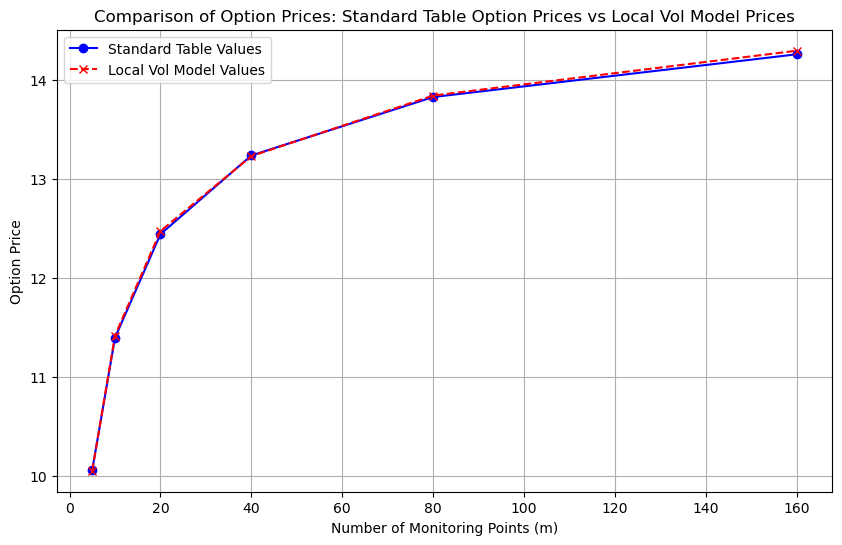

In [24]:
import matplotlib.pyplot as plt

# Plotting the comparison for Table 3
plt.figure(figsize=(10, 6))

# Plotting standard table values
plt.plot(standard_values_table3.keys(), standard_values_table3.values(), marker='o', linestyle='-', color='b', label='Standard Table Values')

# Plotting local vol model values
plt.plot(local_vol_values_table3.keys(), local_vol_values_table3.values(), marker='x', linestyle='--', color='r', label='Local Vol Model Values')

plt.xlabel('Number of Monitoring Points (m)')
plt.ylabel('Option Price')
plt.title('Comparison of Option Prices: Standard Table Option Prices vs Local Vol Model Prices')
plt.legend()
plt.grid(True)
plt.show()
